# Objective:  Analyze past emissions, recognize trends and predict future CO2 emissions from aviation in the EU

# Libraries

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Seasonality

import statsmodels.tsa.api as tsa

# Correlation

from pandas.plotting import autocorrelation_plot 
from statsmodels.tsa.stattools import acf

# EU Analysis - Predictions

#!pip install pmdarima

import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Getting file and data

In [7]:
co2 = pd.read_excel("C:/Users/filip/Desktop/masters/semester 2/PDS - Programming for Data Science/CO2_emissions_by_state.xlsx", sheet_name="DATA")

In [8]:
co2

,YEAR,MONTH,STATE_NAME,STATE_CODE,CO2_QTY_TONNES,TF
0,2010,1,ALBANIA,LA,8.318420e+03,821
1,2010,1,ARMENIA,UD,1.345668e+04,662
2,2010,1,AUSTRIA,LO,1.715352e+05,14972
3,2010,1,BELGIUM,EB,3.090928e+05,11546
4,2010,1,BOSNIA AND HERZEGOVINA,LQ,2.887995e+03,478
...,...,...,...,...,...,...
7656,2025,1,SPAIN,LE,1.313271e+06,58784
7657,2025,1,SWEDEN,ES,1.581149e+05,12768
7658,2025,1,SWITZERLAND,LS,4.483472e+05,19423
7659,2025,1,TÜRKIYE,LT,1.419720e+06,52983


In [9]:
co2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7661 entries, 0 to 7660
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   YEAR            7661 non-null   int64  
 1   MONTH           7661 non-null   int64  
 2   STATE_NAME      7661 non-null   object 
 3   STATE_CODE      7661 non-null   object 
 4   CO2_QTY_TONNES  7661 non-null   float64
 5   TF              7661 non-null   int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 359.2+ KB


# Transforming date

In [11]:
co2["DATE"] = pd.to_datetime(co2["YEAR"].astype(str) + '-' + co2["MONTH"].astype(str), format="%Y-%m")
co2=co2.drop(columns=["YEAR","MONTH"])
co2=co2.set_index(co2["DATE"])
co2=co2.drop(columns="DATE")
co2

,STATE_NAME,STATE_CODE,CO2_QTY_TONNES,TF
DATE,,,,
2010-01-01,ALBANIA,LA,8.318420e+03,821
2010-01-01,ARMENIA,UD,1.345668e+04,662
2010-01-01,AUSTRIA,LO,1.715352e+05,14972
2010-01-01,BELGIUM,EB,3.090928e+05,11546
2010-01-01,BOSNIA AND HERZEGOVINA,LQ,2.887995e+03,478
...,...,...,...,...
2025-01-01,SPAIN,LE,1.313271e+06,58784
2025-01-01,SWEDEN,ES,1.581149e+05,12768
2025-01-01,SWITZERLAND,LS,4.483472e+05,19423


# EU Analysis

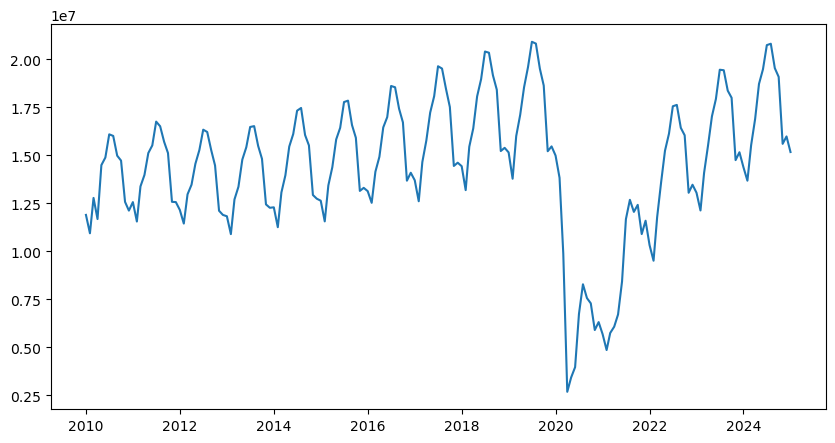

In [13]:
# Create a series

co2_sum = co2.groupby(co2.index)["CO2_QTY_TONNES"].sum()

co2_series=pd.Series(co2_sum)

co2_series.index = pd.to_datetime(co2_series.index)

# Plot series

plt.figure(figsize=(10,5))
plt.plot(co2_series)
plt.show()

In [14]:
sum_year = co2.groupby(co2.index.year)["CO2_QTY_TONNES"].sum()
print(sum_year)

DATE
2010    1.631514e+08
2011    1.713121e+08
2012    1.661430e+08
2013    1.669763e+08
2014    1.741534e+08
2015    1.788042e+08
2016    1.872112e+08
2017    1.961970e+08
2018    2.054244e+08
2019    2.107164e+08
2020    9.084091e+07
2021    1.087988e+08
2022    1.707308e+08
2023    1.948887e+08
2024    2.104199e+08
2025    1.516909e+07
Name: CO2_QTY_TONNES, dtype: float64


# EU Analysis - Seasonality

<Figure size 1500x1000 with 0 Axes>

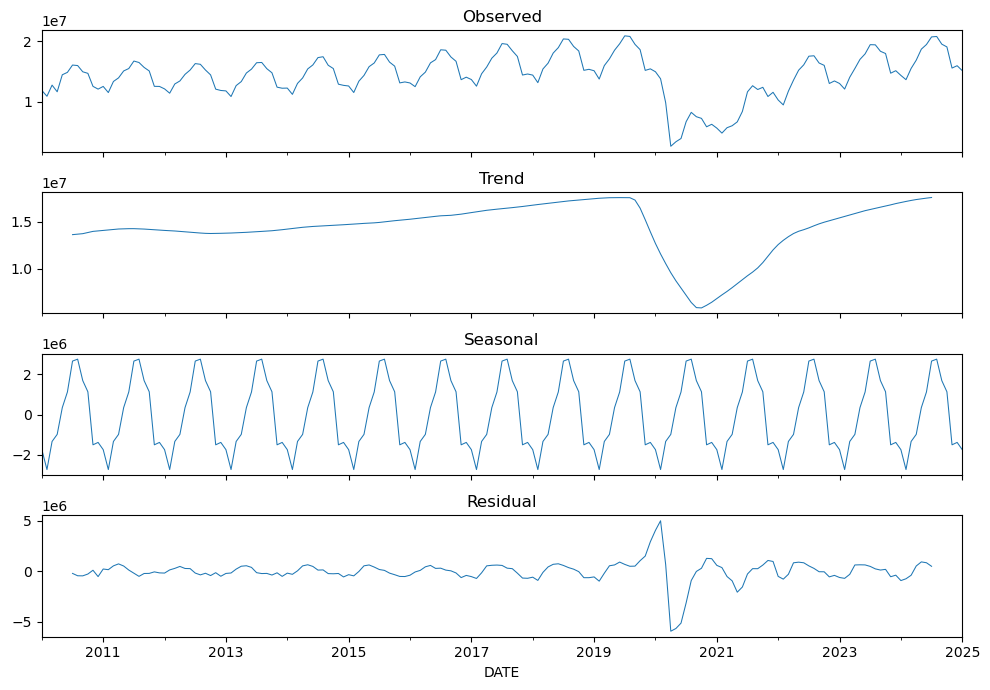

In [16]:
# Using Classical Decomposition

season= tsa.seasonal_decompose(co2_series, model= "additive", period=12)

plt.figure(figsize=(15,10))

fig, axes = plt.subplots(4, 1, figsize=(10,7), sharex=True)

season.observed.plot(ax=axes[0], linewidth=0.75, title="Observed")
season.trend.plot(ax=axes[1], linewidth=0.75, title="Trend")
season.seasonal.plot(ax=axes[2], linewidth=0.75, title="Seasonal")
season.resid.plot(ax=axes[3], linewidth=0.75, title="Residual")


plt.tight_layout()
plt.show()

# EU Analysis - Autocorrelation plots

[ 1.          0.91616361  0.78393328  0.6100904   0.43153981  0.31025879
  0.22359328  0.2158575   0.24444957  0.32315335  0.39392166  0.42781574
  0.4366068   0.34016674  0.21833128  0.0634184  -0.08837295 -0.19041913
 -0.26156646 -0.25834348 -0.22241153 -0.13732337 -0.06127107]


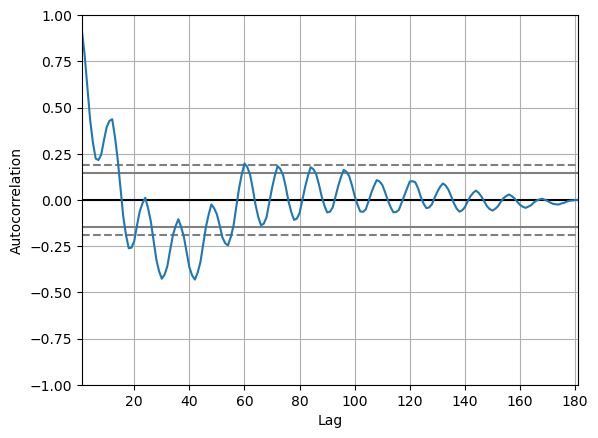

<Figure size 1000x500 with 0 Axes>

In [18]:
autocorrelation_plot(co2_series)
plt.figure(figsize=(10,5))
autocorr_values = acf(co2_series)
print(autocorr_values)

# EU Analysis - Training, Creating a model, Predicting test set

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=2943.842, Time=2.25 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2930.126, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2934.377, Time=0.57 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2971.197, Time=0.51 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=3009.715, Time=0.19 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=3009.301, Time=0.36 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=3004.945, Time=0.73 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2933.178, Time=0.27 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2970.798, Time=0.23 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=2946.231, Time=0.42 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=2931.365, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 5.790 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y  

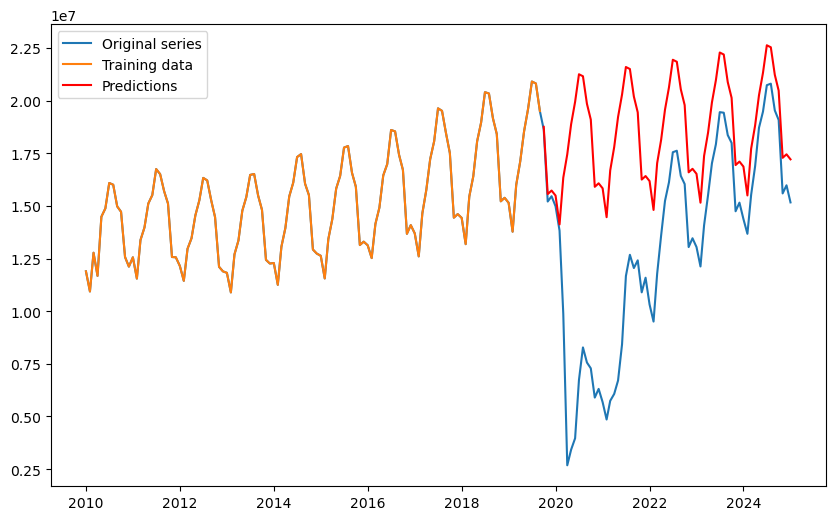

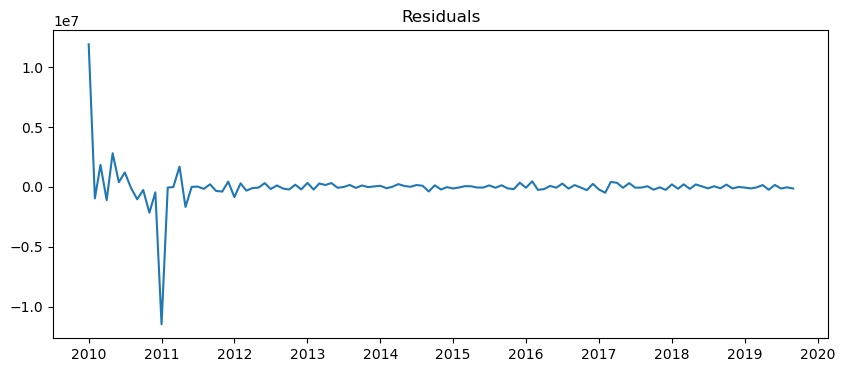

In [20]:
# Splitting training and test data
train_size = int(len(co2_series) * 0.65)
train, test = co2_series[:train_size], co2_series[train_size:]

# Fit ARIMA model on the training data
model = pm.auto_arima(train,
                    start_p=1, start_q=1, max_p=5, max_q=3,
                    seasonal=True, m=12,
                    stepwise=True, trace=True)

print(model.summary())

# Make predictions on the test data
predictions, conf_int = model.predict(n_periods=len(test), return_conf_int=True)
predictions = pd.Series(predictions, index=test.index)

# Calculate RMSE and MAE
rmse = math.sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# Plot the training data, test data and predictions
plt.figure(figsize=(10, 6))
plt.plot(co2_series, label="Original series")
plt.plot(train.index, train, label="Training data")
plt.plot(test.index, predictions, label="Predictions", color='red')
plt.legend()
plt.show()

# Plot residuals (to see if they look like white noise)
residuals = model.resid()
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title("Residuals")
plt.show()


# EU Analysis - Forecasts

C:\Users\filip\AppData\Local\Temp\ipykernel_17260\736170660.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=co2_series.index[-1], periods=n_forecast + 1, freq='M')[1:]


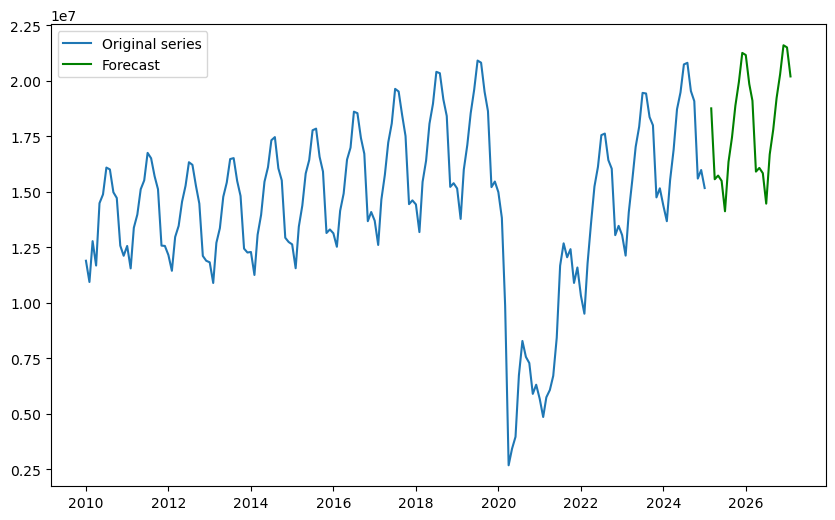

In [22]:
# Forecast future values (after evaluating on the test set)
n_forecast = 24
forecast, conf_int = model.predict(n_periods=n_forecast, return_conf_int=True)
forecast_index = pd.date_range(start=co2_series.index[-1], periods=n_forecast + 1, freq='M')[1:]

plt.figure(figsize=(10, 6))
plt.plot(co2_series, label="Original series")
plt.plot(forecast_index, forecast, label="Forecast", color='green')
plt.legend()
plt.show()

# Finding the greatest contributors to emissions


## Some adjustments to the dataframe

In [25]:
co2=co2.drop(columns="STATE_CODE")
co2

,STATE_NAME,CO2_QTY_TONNES,TF
DATE,,,
2010-01-01,ALBANIA,8.318420e+03,821
2010-01-01,ARMENIA,1.345668e+04,662
2010-01-01,AUSTRIA,1.715352e+05,14972
2010-01-01,BELGIUM,3.090928e+05,11546
2010-01-01,BOSNIA AND HERZEGOVINA,2.887995e+03,478
...,...,...,...
2025-01-01,SPAIN,1.313271e+06,58784
2025-01-01,SWEDEN,1.581149e+05,12768
2025-01-01,SWITZERLAND,4.483472e+05,19423


## Calculate total emissions per Country

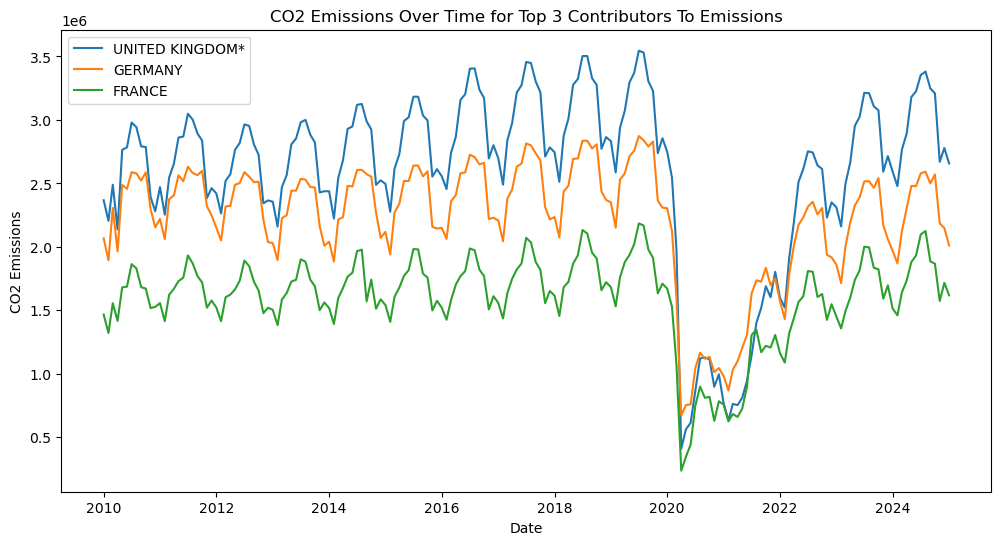

Index(['UNITED KINGDOM*', 'GERMANY', 'FRANCE'], dtype='object', name='STATE_NAME')


In [27]:
country_time_summary = co2.groupby(['STATE_NAME', 'DATE']).agg({
    'CO2_QTY_TONNES': 'sum',
    'TF': 'sum'
})

country_total_emissions = co2.groupby('STATE_NAME')['CO2_QTY_TONNES'].sum()

# Get the top 3 countries with more total emissions
top_3_countries = country_total_emissions.sort_values(ascending=False).head(3).index

# Create the timeline plot
plt.figure(figsize=(12, 6))
for country in top_3_countries:
    country_data = country_time_summary.loc[country]
    plt.plot(country_data.index, country_data['CO2_QTY_TONNES'], label=country)

plt.title('CO2 Emissions Over Time for Top 3 Contributors To Emissions')
plt.xlabel('Date')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.show()

print(top_3_countries)

## Top 3 country's emissions - Seasonality

Seasonality for UNITED KINGDOM*


<Figure size 1500x1000 with 0 Axes>

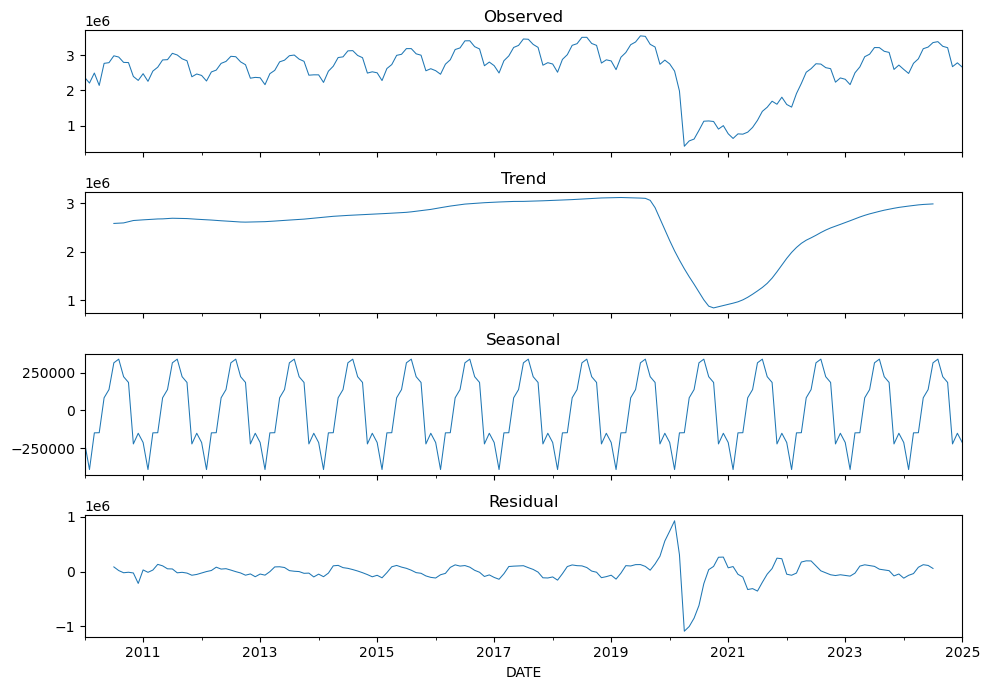

Seasonality for GERMANY


<Figure size 1500x1000 with 0 Axes>

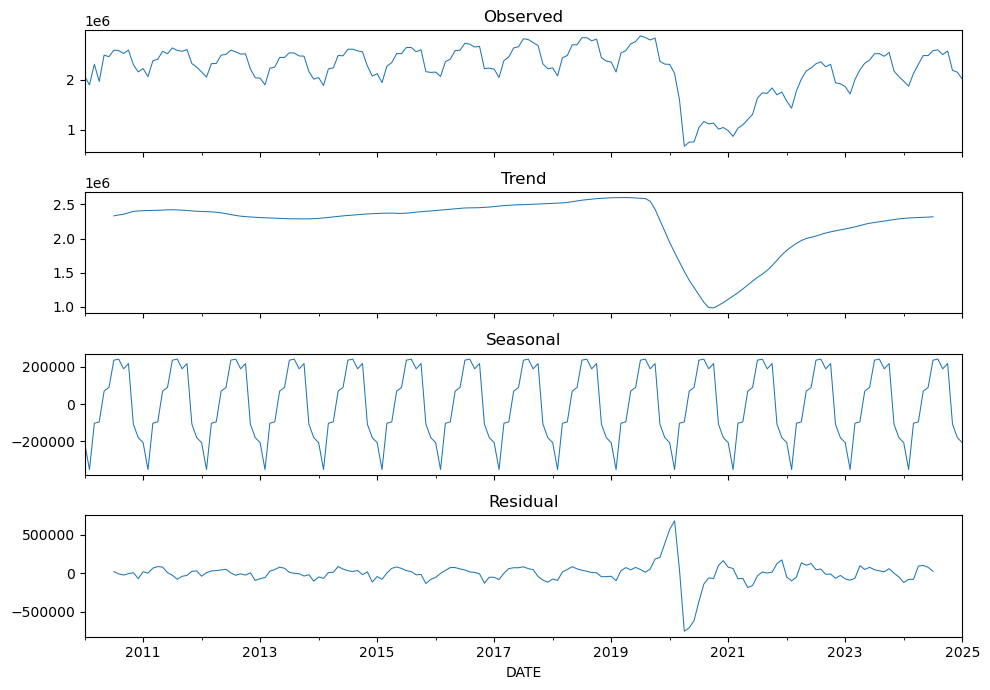

Seasonality for FRANCE


<Figure size 1500x1000 with 0 Axes>

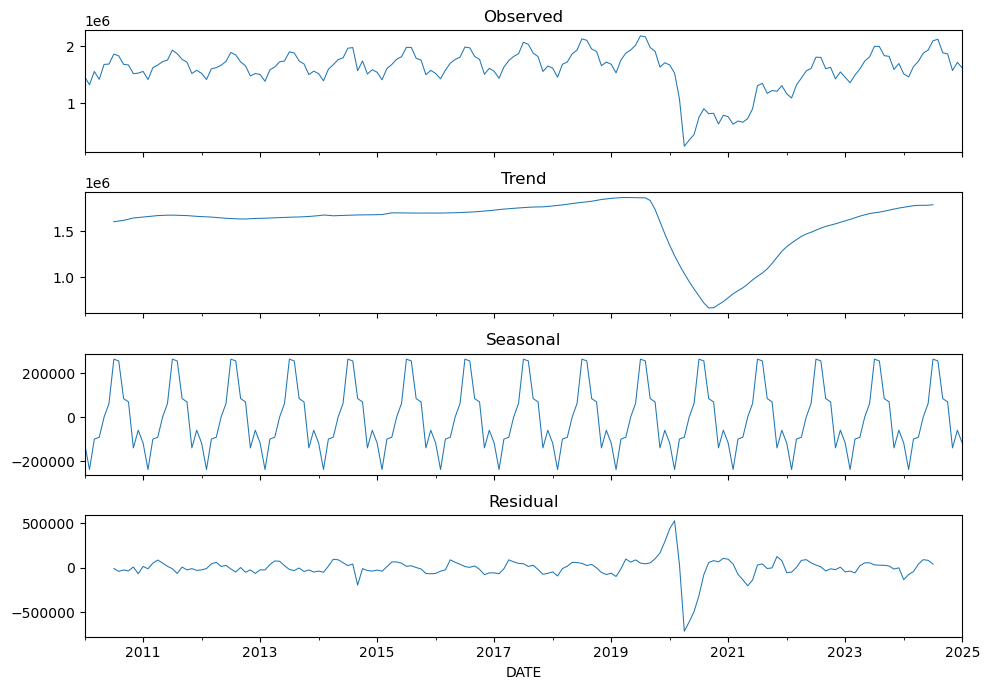

In [29]:
for country in top_3_countries:
    co2_country_specific = co2[co2['STATE_NAME'] == country]  # Filter data
    
    co2_only_country = co2_country_specific['CO2_QTY_TONNES']
    
    # Using Classical Decomposition
    print(f'Seasonality for {country}')

    season= tsa.seasonal_decompose(co2_only_country, model= "additive", period=12)
    
    plt.figure(figsize=(15,10))
    
    fig, axes = plt.subplots(4, 1, figsize=(10,7), sharex=True)
    
    plt.title({country})
    season.observed.plot(ax=axes[0], linewidth=0.75, title="Observed")
    season.trend.plot(ax=axes[1], linewidth=0.75, title="Trend")
    season.seasonal.plot(ax=axes[2], linewidth=0.75, title="Seasonal")
    season.resid.plot(ax=axes[3], linewidth=0.75, title="Residual")
    
    plt.tight_layout()
    plt.show()

## Top 3 country's emissions - Training, Creating a model, Predicting test set and Forecasting

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=2771.904, Time=2.24 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2679.743, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2694.027, Time=0.84 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2679.334, Time=0.76 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2724.708, Time=0.08 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=2679.285, Time=0.19 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=2679.628, Time=0.36 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=2675.531, Time=1.30 sec
 ARIMA(0,0,1)(2,1,1)[12] intercept   : AIC=2640.847, Time=2.15 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=2647.759, Time=1.86 sec
 ARIMA(0,0,1)(2,1,2)[12] intercept   : AIC=2641.232, Time=5.18 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=2642.059, Time=2.44 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=2648.324, Time=2.39 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=2686.625, Time=5.56 sec
 ARIMA(0,0,2)(2,1,1

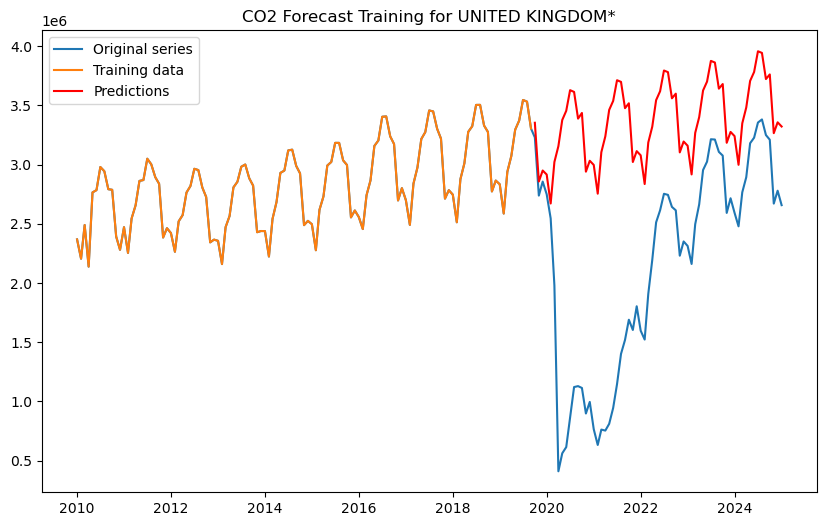

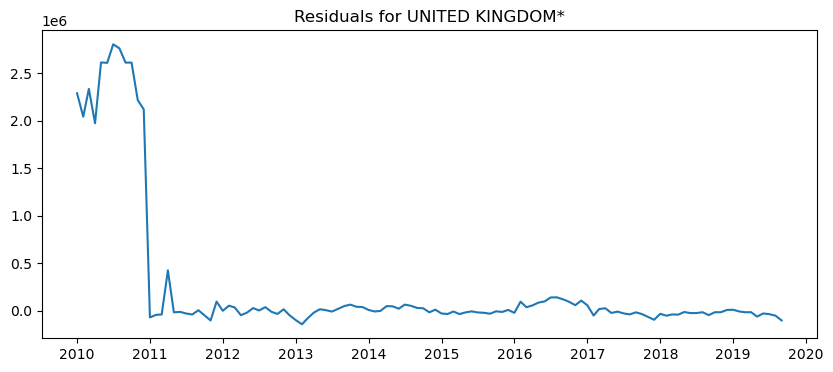

C:\Users\filip\AppData\Local\Temp\ipykernel_17260\2105549258.py:49: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=co2_only_country.index[-1], periods=n_forecast + 1, freq='M')[1:]


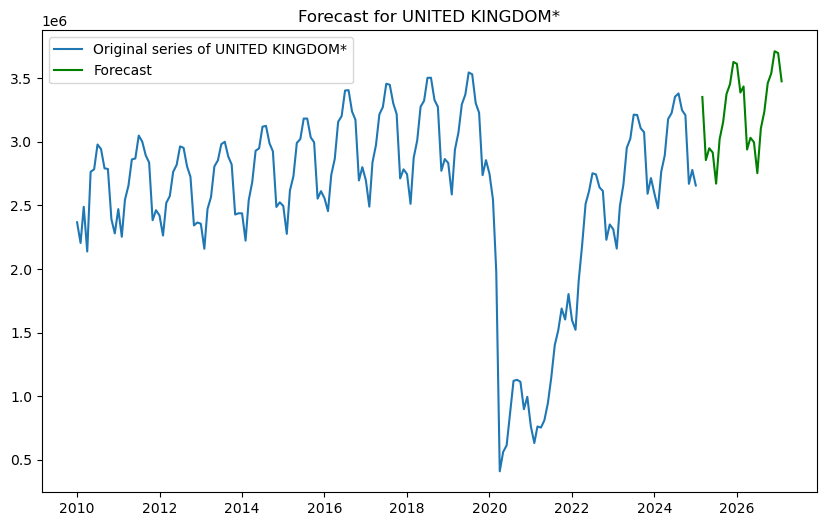

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=2640.234, Time=1.83 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2670.475, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2665.187, Time=0.30 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2662.291, Time=0.40 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2684.404, Time=0.07 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=2698.950, Time=1.03 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=2699.093, Time=0.68 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=2608.952, Time=2.55 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=2653.454, Time=2.57 sec
 ARIMA(1,0,1)(2,1,2)[12] intercept   : AIC=inf, Time=6.48 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=2610.697, Time=4.99 sec
 ARIMA(0,0,1)(2,1,1)[12] intercept   : AIC=2616.550, Time=2.93 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.48 sec
 ARIMA(2,0,1)(2,1,1)[12] intercept   : AIC=2613.780, Time=5.81 sec
 ARIMA(1,0,2)(2,1,1)[12] inte

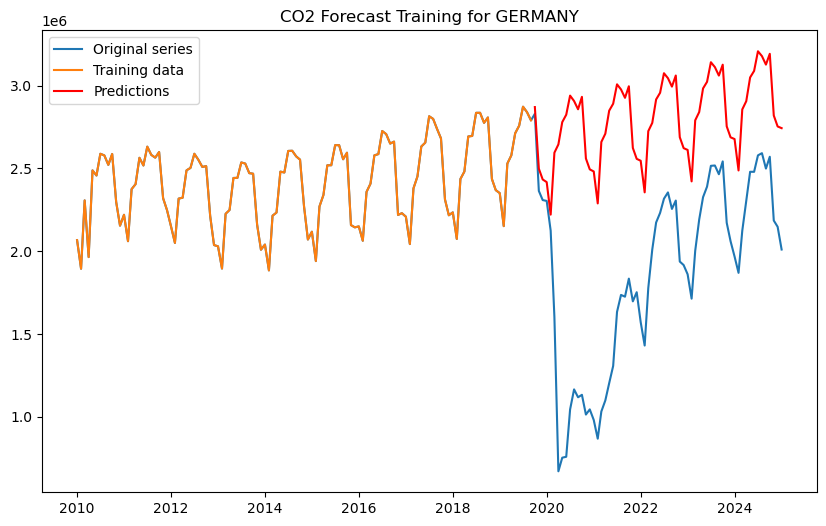

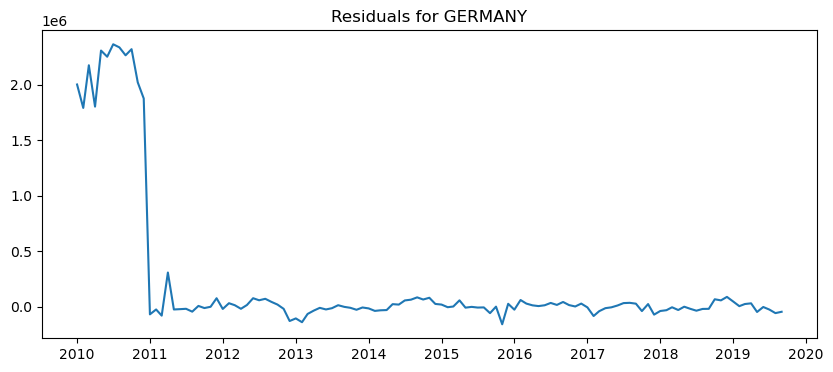

C:\Users\filip\AppData\Local\Temp\ipykernel_17260\2105549258.py:49: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=co2_only_country.index[-1], periods=n_forecast + 1, freq='M')[1:]


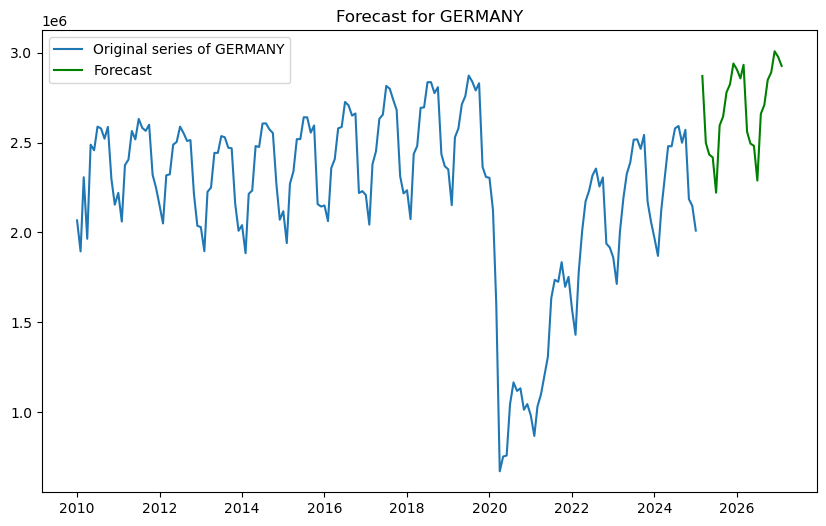

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=2574.109, Time=2.60 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2587.046, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2581.630, Time=0.47 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2581.000, Time=0.49 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2615.643, Time=0.04 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=2586.009, Time=0.80 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=2586.303, Time=0.79 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=2555.623, Time=3.31 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=2558.030, Time=3.25 sec
 ARIMA(1,0,1)(2,1,2)[12] intercept   : AIC=2555.547, Time=4.90 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=3.34 sec
 ARIMA(0,0,1)(2,1,2)[12] intercept   : AIC=2559.476, Time=4.31 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=2556.560, Time=4.21 sec
 ARIMA(2,0,1)(2,1,2)[12] intercept   : AIC=2560.529, Time=5.12 sec
 ARIMA(1,0,2)(2,1,2)[12]

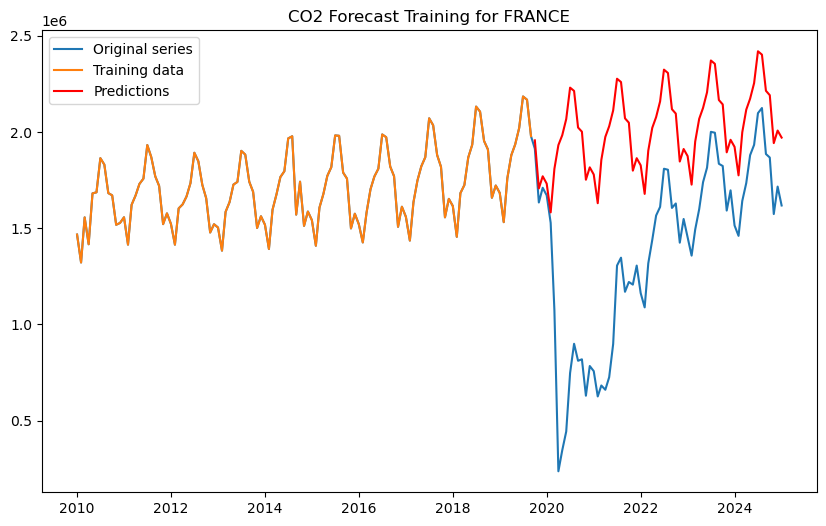

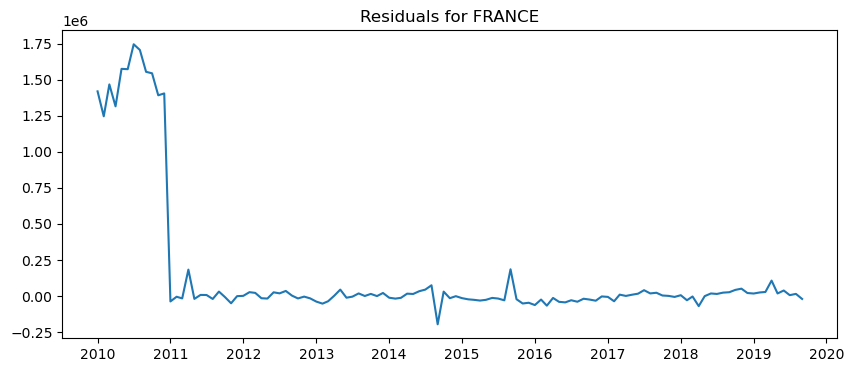

C:\Users\filip\AppData\Local\Temp\ipykernel_17260\2105549258.py:49: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=co2_only_country.index[-1], periods=n_forecast + 1, freq='M')[1:]


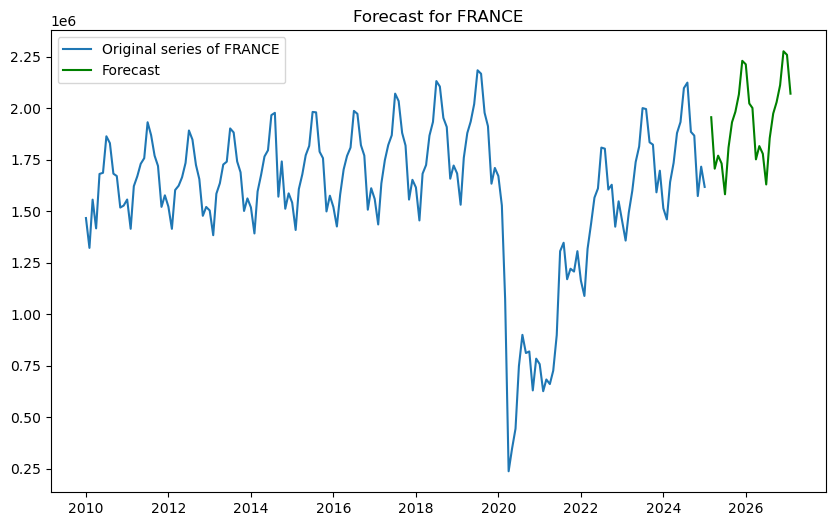

In [31]:
for country in top_3_countries:
    co2_country_specific = co2[co2['STATE_NAME'] == country]  # Filter data
    
    # Extract the CO2_emissions column for training and testing
    co2_only_country = co2_country_specific['CO2_QTY_TONNES']
  
    # Splitting training and test data
    train_size = int(len(co2_only_country) * 0.65)
    train, test = co2_only_country[:train_size], co2_only_country[train_size:]
    
    # Fit ARIMA model on the training data
    model = pm.auto_arima(train,
                        start_p=1, start_q=1, max_p=2, max_q=2,
                        seasonal=True, m=12,
                        stepwise=True, trace=True)
    
    print(model.summary())
    
    # Make predictions on the test data
    predictions, conf_int = model.predict(n_periods=len(test), return_conf_int=True)
    predictions = pd.Series(predictions, index=test.index)
    
    # Calculate RMSE and MAE
    rmse = math.sqrt(mean_squared_error(test, predictions))
    mae = mean_absolute_error(test, predictions)
    
    print(f"{country} - RMSE: {rmse}")
    print(f"{country} - MAE: {mae}")
    
    # Plot the training data, test data and predictions
    plt.figure(figsize=(10, 6))
    plt.plot(co2_only_country, label="Original series")
    plt.plot(train.index, train, label="Training data")
    plt.plot(test.index, predictions, label="Predictions", color='red')
    plt.legend()
    plt.title(f"CO2 Forecast Training for {country}")
    plt.show()
    
    # Plot residuals (to see if they look like white noise)
    residuals = model.resid()
    plt.figure(figsize=(10, 4))
    plt.plot(residuals)
    plt.title(f"Residuals for {country}")
    plt.show()

        # Forecast future values
    n_forecast = 24
    forecast, conf_int = model.predict(n_periods=n_forecast, return_conf_int=True)
    forecast_index = pd.date_range(start=co2_only_country.index[-1], periods=n_forecast + 1, freq='M')[1:]

    plt.figure(figsize=(10, 6))
    plt.plot(co2_only_country, label=f"Original series of {country}")
    plt.plot(forecast_index, forecast, label="Forecast", color='green')
    plt.legend()
    plt.title(f'Forecast for {country}')
    plt.show()